<h1> OpenSees Examples Manual Examples for OpenSeesPy</h1>
<h2>OpenSees Example 1a. 2D Elastic Cantilever Column -- Static Pushover</h2>
<p>

You can find the original Examples:<br>
https://opensees.berkeley.edu/wiki/index.php/Examples_Manual<br>
Original Examples by By Silvia Mazzoni & Frank McKenna, 2006, in Tcl<br>
Converted to OpenSeesPy by SilviaMazzoni, 2020<br>
<p>

<h2> Simulation Process</h2>

Each example script does the following:
<h3>A. Build the model</h3>
<ol>
    <li>model dimensions and degrees-of-freedom</li>
    <li>nodal coordinates</li>
    <li>nodal constraints -- boundary conditions</li>
    <li>nodal masses</li>
    <li>elements and element connectivity</li>
    <li>recorders for output</li>
</ol>
<h3>B. Define & apply gravity load</h3>
<ol>
    <li>nodal or element load</li>
    <li>static-analysis parameters (tolerances & load increments)</li>
    <li>analyze</li>
    <li>hold gravity loads constant</li>
    <li>reset time to zero</li>
</ol>
<h3>C. Define and apply lateral load</h3>
<dl>
<li>Time Series and Load Pattern (nodal loads for static analysis, support ground motion for earthquake)</li>
<li>lateral-analysis parameters (tolerances and displacement/time increments)</li>
<b>Static Lateral-Load Analysis</b>
<li>define the displacement increments and displacement path</li>
<b>Dynamic Lateral-Load Analysis</b>
<li>define the input motion and all associated parameters, such as scaling and input type</li>
<li>define analysis duration and time increment</li>
<li>define damping</li>
<li>analyze</li>
<p>

<b>Introductory Examples</b>
The objective of Example 1a and Example 1b is to give an overview of input-file format in OpenSees using simple scripts.
These scripts do not take advantage of the Tcl scripting capabilities shown in the later examples. However, they do provide starting a place where the input file is similar to that of more familiar Finite-Element Analysis software. Subsequent examples should be used as the basis for user input files.
    

<h1> OpenSees Example 1a. 2D Elastic Cantilever Column -- Static Pushover</h1>
Introduction
Example 1a is a simple model of an elastic cantilever column. 
    <b> Objectives of Example 1b </b>
    - overview of basic OpenSees input structure<br>
    - coordinates, boundary conditions, element connectivity, nodal masses, nodal loads, etc.<br>
    - two-node, one element
<img src="https://opensees.berkeley.edu/wiki/images/e/ec/Example1a_Push.GIF">


In [1]:
############################################################
#  EXAMPLE: 
#       pyEx1a.Canti2D.Push.tcl.py
#          for OpenSeesPy
#  --------------------------------------------------------#
#  by: Silvia Mazzoni, 2020
#       silviamazzoni@yahoo.com
############################################################
# This file was obtained from a conversion of the updated Tcl script
############################################################

# configure Python workspace
import openseespy.opensees as ops
import eSEESminiPy
import os
import math
import numpy as numpy
import matplotlib.pyplot as plt
ops.wipe()
# --------------------------------------------------------------------------------------------------
# Example 1. cantilever 2D
# static pushover analysis with gravity.
# all units are in kip, inch, second
# elasticBeamColumn ELEMENT
# Silvia Mazzoni and Frank McKenna, 2006
#
# ^Y
# or
# 2 __
# or  |
# or  |
# or  |
# (1) 36'
# or  |
# or  |
# or  |
# =1= ---- -------->X
#

# SET UP ----------------------------------------------------------------------------
ops.wipe()     #  clear opensees model
ops.model('basic','-ndm',2,'-ndf',3)     #  2 dimensions, 3 dof per node
if not os.path.exists('Data'):
    os.mkdir('Data')

# define GEOMETRY -------------------------------------------------------------
# nodal coordinates:
ops.node(1,0,0)     #  node , X Y
ops.node(2,0,432)

# Single point constraints -- Boundary Conditions
ops.fix(1,1,1,1)     #  node DX DY RZ

# nodal masses:
ops.mass(2,5.18,0.,0.)     #  node , Mx My Mz, Mass=Weight/g.

# Define ELEMENTS -------------------------------------------------------------
# define geometric transformation: performs a linear geometric transformation of beam stiffness
# and resisting force from the basic system to the global-coordinate system
ops.geomTransf('Linear',1)     #  associate a tag to transformation

# connectivity: (make A very large, 10e6 times its actual value)
# element elasticBeamColumn eleTag iNode jNode A E Iz transfTag
ops.element('elasticBeamColumn',1,1,2,3600000000,4227,1080000,1)     # element elasticBeamColumn 1 1 2 3600000000 4227 1080000 1;

# Define RECORDERS -------------------------------------------------------------
ops.recorder('Node','-file','Data/DFreeEx1aPush.out','-time','-node',2,'-dof',1,2,3,'disp')     #  displacements of free nodes
ops.recorder('Node','-file','Data/DBaseEx1aPush.out','-time','-node',1,'-dof',1,2,3,'disp')     #  displacements of support nodes
ops.recorder('Node','-file','Data/RBaseEx1aPush.out','-time','-node',1,'-dof',1,2,3,'reaction')     #  support reaction
ops.recorder('Element','-file','Data/FColEx1aPush.out','-time','-ele',1,'globalForce')     #  element forces -- column
ops.recorder('Element','-file','Data/DColEx1aPush.out','-time','-ele',1,'deformation')     #  element deformations -- column

# define GRAVITY -------------------------------------------------------------
ops.timeSeries('Linear',1)     # timeSeries Linear 1;
# define Load Pattern
ops.pattern('Plain',1,1) # 
ops.load(2,0.,-2000.,0.)     #  node , FX FY MZ -- superstructure-weight

ops.wipeAnalysis()     # adding this to clear Analysis module 
ops.constraints('Plain')     #  how it handles boundary conditions
ops.numberer('Plain')     #  renumber dofs to minimize band-width (optimization), if you want to
ops.system('BandGeneral')     #  how to store and solve the system of equations in the analysis
ops.test('NormDispIncr',1.0e-8,6)     #  determine if convergence has been achieved at the end of an iteration step
ops.algorithm('Newton')     #  use Newtons solution algorithm: updates tangent stiffness at every iteration
ops.integrator('LoadControl',0.1)     #  determine the next time step for an analysis,   apply gravity in 10 steps
ops.analysis('Static')     #  define type of analysis static or transient
ops.analyze(10)     #  perform gravity analysis
ops.loadConst('-time',0.0)     #  hold gravity constant and restart time

# define LATERAL load -------------------------------------------------------------
# Lateral load pattern
ops.timeSeries('Linear',2)     # timeSeries Linear 2;
# define Load Pattern
ops.pattern('Plain',2,2) # 
ops.load(2,2000.,0.0,0.0)     #  node , FX FY MZ -- representative lateral load at top node


# pushover: diplacement controlled static analysis
ops.integrator('DisplacementControl',2,1,0.1)     #  switch to displacement control, for node 11, dof 1, 0.1 increment
ops.analyze(1000)     #  apply 100 steps of pushover analysis to a displacement of 10

print('Done!')


Done!


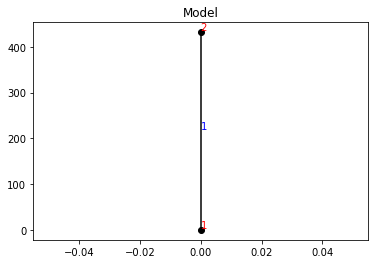

In [2]:
eSEESminiPy.drawModel()


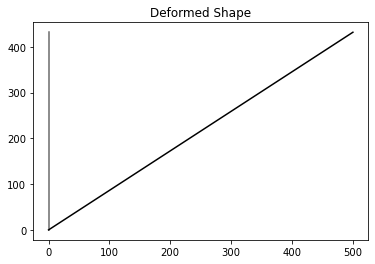

In [3]:
# plot deformed shape at end of analysis (it may have returned to rest)
# amplify the deformtions by 5
eSEESminiPy.drawDeformedShape(5)

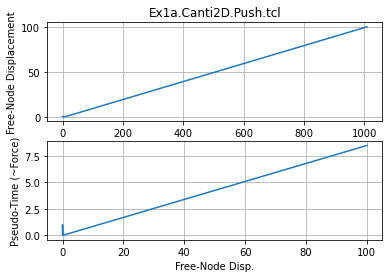

End of Run: pyEx1a.Canti2D.Push.tcl.py


In [4]:
ops.wipe() # the wipe command here closes all recorder files
plt.close('all')
fname3 = 'Data/DFreeEx1aPush.out'
dataDFree = numpy.loadtxt(fname3)
plt.subplot(211)
plt.title('Ex1a.Canti2D.Push.tcl')
plt.grid(True)
plt.plot(dataDFree[:,1])
plt.xlabel('Step Number')
plt.ylabel('Free-Node Displacement')
plt.subplot(212)
plt.grid(True)
plt.plot(dataDFree[:,1],dataDFree[:,0])
plt.xlabel('Free-Node Disp.')
plt.ylabel('Pseudo-Time (~Force)')
plt.show()
print('End of Run: pyEx1a.Canti2D.Push.tcl.py')
